In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython
import IPython.display
import PIL
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['freesound-audio-tagging-2019', 'fat2019_prep_mels1']


In [2]:
! ls ../input/fat2019_prep_mels1

mels_test.pkl		mels_train_noisy.pkl	    trn_noisy_best50s.csv
mels_train_curated.pkl	mels_trn_noisy_best50s.pkl


## utils

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

In [4]:
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

## File/folder definitions

- `df` will handle training data.
- `test_df` will handle test data.

In [5]:
DATA = Path('../input/freesound-audio-tagging-2019')
PREPROCESSED = Path('../input/fat2019_prep_mels1')
WORK = Path('work')
Path(WORK).mkdir(exist_ok=True, parents=True)

CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_TRN_NOISY_BEST50S = PREPROCESSED/'trn_noisy_best50s.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'

MELS_TRN_CURATED = PREPROCESSED/'mels_train_curated.pkl'
MELS_TRN_NOISY = PREPROCESSED/'mels_train_noisy.pkl'
MELS_TRN_NOISY_BEST50S = PREPROCESSED/'mels_trn_noisy_best50s.pkl'
MELS_TEST = PREPROCESSED/'mels_test.pkl'

trn_curated_df = pd.read_csv(CSV_TRN_CURATED)
trn_noisy_df = pd.read_csv(CSV_TRN_NOISY)
trn_noisy50s_df = pd.read_csv(CSV_TRN_NOISY_BEST50S)
test_df = pd.read_csv(CSV_SUBMISSION)

#df = pd.concat([trn_curated_df, trn_noisy_df], ignore_index=True) # not enough memory
df = pd.concat([trn_curated_df, trn_noisy50s_df], ignore_index=True, sort=True)
test_df = pd.read_csv(CSV_SUBMISSION)

X_train = pickle.load(open(MELS_TRN_CURATED, 'rb')) + pickle.load(open(MELS_TRN_NOISY_BEST50S, 'rb'))

## Custom `open_image` for fast.ai library to load data from memory

- Important note: Random cropping 1 sec, this is working like augmentation.

In [6]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
from fastai.callbacks import *
import random

CUR_X_FILES, CUR_X = list(df.fname.values), X_train

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop 1sec
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

## Follow multi-label classification

- Almost following fast.ai course: https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb
- But `pretrained=False`

In [7]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK, Path('..')/CSV_TRN_CURATED, folder='trn_curated')
       .split_none()
       .label_from_df(label_delim=',')
)
data = (src.transform(tfms, size=128)
        .databunch(bs=128).normalize(imagenet_stats)
)

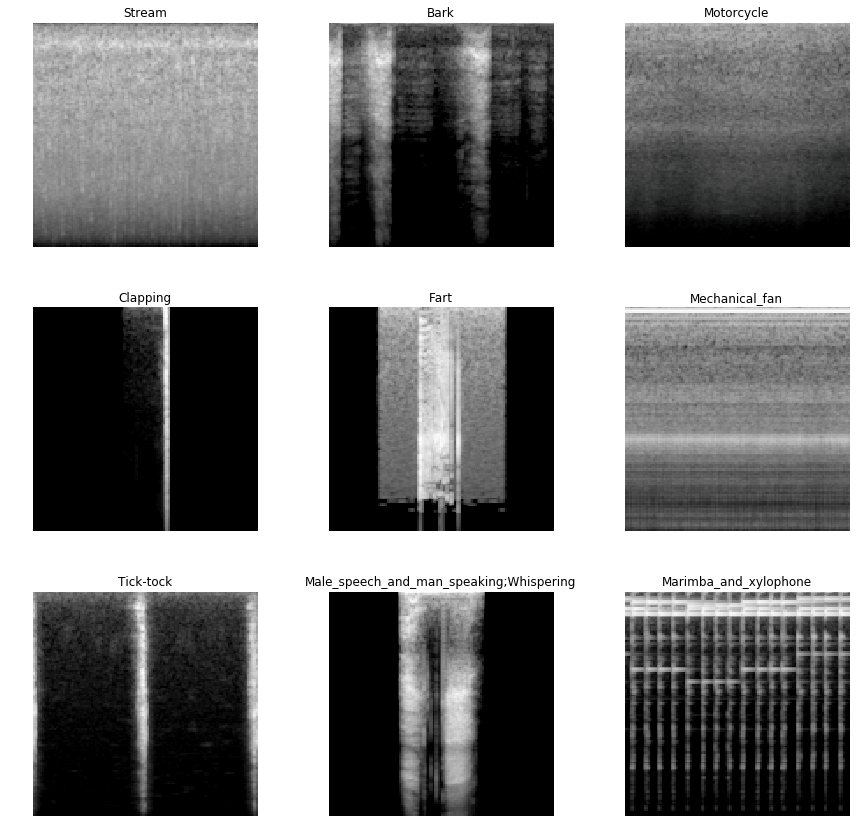

In [8]:
data.show_batch(3)

In [9]:
def lwlrap(y_pred,y_true):
    score, weight = calculate_per_class_lwlrap(y_true.cpu().numpy(), y_pred.cpu().numpy())
    lwlrap = (score * weight).sum()
    return torch.from_numpy(np.array(lwlrap))

In [10]:
class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            new_input = (last_input * lambd.view(lambd.size(0),1,1,1) + x1 * (1-lambd).view(lambd.size(0),1,1,1))
        if self.stack_y:
            new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
        

class MixUpLoss(nn.Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) == 2:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            d = (loss1 * target[:,2] + loss2 * (1-target[:,2])).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum':            return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

def mixup(learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True) -> Learner:
    "Add mixup https://arxiv.org/abs/1710.09412 to `learn`."
    learn.callback_fns.append(partial(MixUpCallback, alpha=alpha, stack_x=stack_x, stack_y=stack_y))
    return learn
Learner.mixup = mixup


In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x
    
class Classifier(nn.Module):
    def __init__(self, num_classes=1000): # <======== modificaition to comply fast.ai
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # <======== modificaition to comply fast.ai
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        #x = torch.mean(x, dim=3)   # <======== modificaition to comply fast.ai
        #x, _ = torch.max(x, dim=2) # <======== modificaition to comply fast.ai
        x = self.avgpool(x)         # <======== modificaition to comply fast.ai
        x = self.fc(x)
        return x

In [12]:
def borrowed_model(pretrained=False, **kwargs):
    return Classifier(**kwargs)

f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, borrowed_model, pretrained=False, metrics=[lwlrap]).mixup(stack_y=False)
learn.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


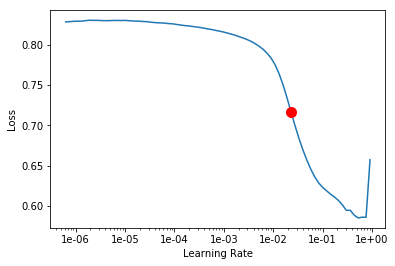

In [13]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
learn.fit_one_cycle(255, 1e-2,callbacks=[SaveModelCallback(learn, every='improvement', monitor='lwlrap', name='best')])

In [15]:
learn.lr_find()
learn.fit_one_cycle(50, 1e-2,callbacks=[SaveModelCallback(learn, every='improvement', monitor='lwlrap', name='best')])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [16]:
learn.export()

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test prediction and making submission file simple
- Switch to test data.
- Overwrite results to sample submission; simple way to prepare submission file.

In [17]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=30) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=30, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

In [18]:
del X_train
X_test = pickle.load(open(MELS_TEST, 'rb'))
CUR_X_FILES, CUR_X = list(test_df.fname.values), X_test


test = ImageList.from_csv(WORK, Path('..')/CSV_SUBMISSION, folder='test')
learn = load_learner(WORK, test=test)
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [19]:
test_df[learn.data.classes] = preds
test_df.to_csv('submission.csv', index=False)
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,-8.633453,-11.290011,-8.550983,-8.539845,-7.764100,-6.078399,-8.942440,-7.914899,-7.669053,-7.823256,-9.271146,-9.134582,-8.750655,-7.852019,-8.154464,-8.366576,-7.716767,-5.827971,-9.540757,-4.743225,-8.313386,-5.800978,-7.826553,-8.624803,-9.088164,-3.929472,-7.641872,-7.204377,-6.561310,-9.636610,-6.218420,-5.112428,-5.648885,-10.315677,-4.174766,-9.395372,-7.455516,-8.527925,-6.736012,...,-7.988923,-2.115471,-5.513062,-5.983694,-8.332046,-8.445725,-7.922481,-6.471959,-11.783754,-7.712280,-8.319259,-9.804339,-9.469754,-9.866200,-8.145185,-6.914551,-10.154695,-1.218142,-9.120591,-4.730927,-8.328643,-8.180019,-6.518279,-8.577885,-5.224625,-8.926161,-7.676513,-9.373624,-5.089380,-7.791397,-7.680282,-11.602680,-7.645573,-9.643902,-7.910481,-9.188018,-4.911529,-4.251680,-7.890056,-8.260128
1,0012633b.wav,-2.596646,-7.204664,-5.701192,-6.688436,-6.954547,-5.574092,-4.280744,-7.105416,-7.684899,-6.554307,-4.769499,-5.376070,-4.515323,-7.370185,-7.986542,-6.082628,-8.238292,-8.095128,-6.925375,-7.943110,-7.506522,-7.159593,-6.705510,-6.363654,-5.646830,-7.883270,-7.704712,-5.864037,-8.036243,-6.014764,-7.599441,-5.606463,-5.807494,-8.912181,-8.065352,-6.548238,-5.391521,-7.960930,-6.370171,...,-4.780172,-5.973777,-5.401756,-7.863563,-7.487076,-5.471431,-5.929438,-7.015672,-6.385305,-7.757482,-6.170404,-2.472335,-6.292405,-7.278671,-4.147056,-7.901870,-6.142318,-8.296024,-7.836508,-7.333899,-5.916035,-7.384439,-7.372618,-6.742655,-5.629910,-5.888550,-8.636030,-6.319594,-7.665012,-8.772034,-6.197370,-5.541955,-10.209412,-6.425885,-7.206085,-6.463430,-7.082573,-5.793635,-7.442470,-5.888978
2,001ed5f1.wav,-5.797198,-4.707514,-6.666852,-6.370002,-6.706985,-6.309349,-6.574790,-5.896303,-8.810856,-7.383320,-5.808563,-6.953132,-6.251215,-6.127443,-6.618367,-5.769478,-7.975355,-7.305633,-7.277200,-6.032866,-6.327330,-5.189652,-6.083686,-7.150908,-3.179566,-8.523305,-8.352425,-6.081225,-7.349897,-5.660979,-7.591095,-8.645030,-5.835248,-8.911490,-5.412066,-6.384038,-6.546175,-8.425536,-4.602340,...,-5.692101,-5.795305,-4.972941,-8.468141,-4.313530,-6.817858,-7.078295,-7.685419,-4.369539,-8.802521,-4.814065,-6.168540,-6.063285,-7.227276,-6.558402,-8.195568,-1.334121,-6.515788,-7.763726,-8.226140,-7.144621,-5.724156,-5.429806,-4.327106,-5.712374,-6.016344,-6.055972,-6.644978,-5.245701,-4.972045,-6.430999,-5.820142,-8.279547,-7.179486,-5.545482,-6.197790,-7.401380,-6.657189,-5.855575,-7.616876
3,00294be0.wav,-11.115314,-12.122578,-9.764742,-12.621972,-7.876230,-7.651736,-10.205730,-10.869747,-7.946227,-8.521602,-8.620877,-11.482716,-10.207159,-13.122934,-6.508237,-9.044742,-10.987609,-8.056093,-12.235991,-10.309597,-8.554635,-8.406652,-6.811882,-12.698741,-10.752584,-9.046219,-11.911539,-7.709830,-10.712168,-10.373876,-8.210104,-8.965846,-7.811252,-8.224167,-9.111918,-9.224908,-9.482497,-7.463038,-8.491583,...,-11.248337,-10.323916,-8.189670,-9.128881,-9.805276,-9.589939,-9.496535